# 2nd Hand Car Price Prediction

In this project we analyze the 'Used Cars' dataset from kaggle (https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data?select=vehicles.csv). 

The goal is to build a model that could estimate the price of second hand cars based on relevant features. We explore the data through cleanig and preprocessing, handling outliers, feature engineering and eventually testing different regression models to get the most accurate predictor.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize']= (20,10)

In [3]:
df1 = pd.read_csv("/Users/marwa/Desktop/2ndHCP/model/vehicles.csv")

The dataset has 426,880 rows and 26 columns

# Data Cleaning

In [6]:
#Drop irrelevant features:
df2= df1.drop(['id', 'url', 'region_url', 'image_url', 'description', 'lat', 
               'long','region', 'VIN', 'title_status', 'type', 'cylinders', 'county', 'model'], axis= 'columns')

In [7]:
# Handling missing values 

#check columns with nan>50%
df2.isnull().mean()*100

price            0.000000
year             0.282281
manufacturer     4.133714
condition       40.785232
fuel             0.705819
odometer         1.030735
transmission     0.598763
drive           30.586347
size            71.767476
paint_color     30.501078
state            0.000000
posting_date     0.015930
dtype: float64

In [8]:
#remove size feature with 71% NaN  
#dataset is large it is efficiet enough to remove all rows with NaN
df2= df2.drop('size', axis='columns')
df3 = df2.dropna()

# Feature Engineering

Remove 'harley-davidson' from manufacturer as it is a motorcycle brand

In [34]:
df4= df3[~(df3.manufacturer== 'harley-davidson')]

Group the manufacturers with counts <100 together as 'other'

In [37]:
manufacturer_count= df4.groupby('manufacturer')['manufacturer'].agg('count').sort_values(ascending = False)
manufacturer_less_than_100 = manufacturer_count[manufacturer_count<100]
df4.manufacturer= df4.manufacturer.apply(lambda x: 'other' if x in manufacturer_less_than_100 else x)

/var/folders/s3/24r6s08x3pg9xyqf7659_57h0000gn/T/ipykernel_2792/2541273670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.manufacturer= df4.manufacturer.apply(lambda x: 'other' if x in manufacturer_less_than_100 else x)


Extract age of each vehicle

In [40]:
# want the feature post_date to be a year only
#first we convert it to a date time for easier manipulation
df4['posting_date'] = pd.to_datetime(df4['posting_date'], utc=True)

#extract the year out of it using dt.year and create a new column
df4['posting_year'] = df4['posting_date'].dt.year

#remove postiing date column
df4= df4.drop('posting_date', axis= 'columns')

#int32 
df4['year']= df4['year'].astype('int32')

df5 = df4.copy()

#calculate age of vehicle
df5['vehicle_age'] = df5['posting_year']-df5['year']

df5=df5.drop(['year', 'posting_year'], axis= 'columns')

/var/folders/s3/24r6s08x3pg9xyqf7659_57h0000gn/T/ipykernel_2792/3632326539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['posting_date'] = pd.to_datetime(df4['posting_date'], utc=True)
/var/folders/s3/24r6s08x3pg9xyqf7659_57h0000gn/T/ipykernel_2792/3632326539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['posting_year'] = df4['posting_date'].dt.year


# Data Cleaning (continued) & Preprocessing
- Outlier Removal
- Duplicates

Target variable price 

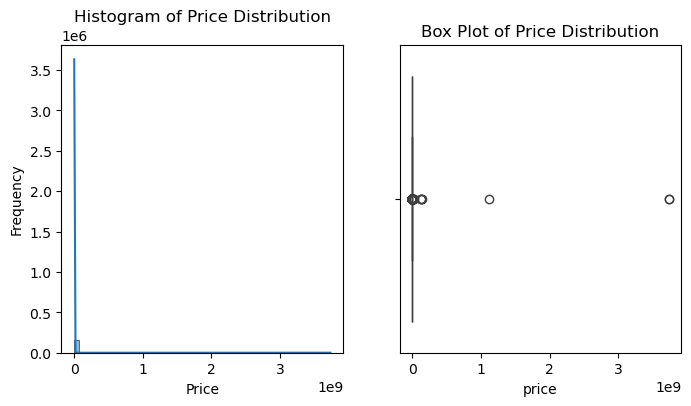

In [71]:
#Visualising target variable price 

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
sns.histplot(df5['price'], bins=50, kde=True)
plt.title('Histogram of Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=df5['price'])
plt.title('Box Plot of Price Distribution')
plt.show()

In [46]:
# check price range

df5.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])

count    1.539630e+05
mean     7.590059e+04
std      1.377825e+07
min      0.000000e+00
25%      6.000000e+03
50%      1.289900e+04
75%      2.399500e+04
85%      3.097700e+04
90%      3.499500e+04
100%     3.736929e+09
max      3.736929e+09
Name: price, dtype: float64

In [50]:
#std extremely high relative to the mean. Possible presence of outliers.
#min=0 indicates that there're samples with no price!! this can't be marketable.
#max= 3.74 billion! is extremely high for a car price! Could be an outlier


#remove price=0
df6= df5[~(df5.price==0)]
df6[df5['price']==0]

#Prices vary in different states
#remove outliers using IQ method on price per state
def remove_outliers(df):
    df_out= pd.DataFrame()
    #group by state
    for key, subdf in df.groupby('state'):
    
        Q1= subdf['price'].quantile(0.25)
        Q3= subdf['price'].quantile(0.75)
        IQR= Q3-Q1

        #define bounds
        lower= Q1 - 1.5 * IQR
        upper= Q3 + 1.5 * IQR
        
        #select prices per state within the bounds
        reduced_df= subdf[(subdf.price>= lower) & (subdf.price<= upper) ]
        df_out= pd.concat([df_out, reduced_df], ignore_index=True)
        
    return df_out

df7=remove_outliers(df6)

/var/folders/s3/24r6s08x3pg9xyqf7659_57h0000gn/T/ipykernel_2792/2559694849.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6[df5['price']==0]


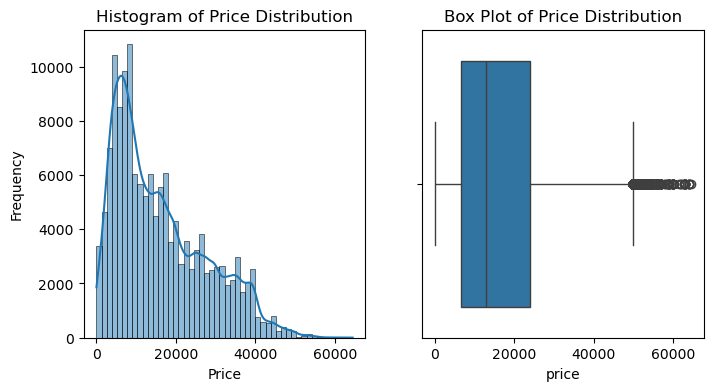

In [69]:
# visualise Price again

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(df7['price'], bins=50, kde=True)
plt.title('Histogram of Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=df7['price'])
plt.title('Box Plot of Price Distribution')
plt.show()

Odometer/ mileage feature

In [74]:
df7['odometer'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]) 

count    1.453330e+05
mean     1.043514e+05
std      1.796574e+05
min      0.000000e+00
25%      4.400000e+04
50%      9.720000e+04
75%      1.438760e+05
85%      1.688034e+05
90%      1.863488e+05
100%     1.000000e+07
max      1.000000e+07
Name: odometer, dtype: float64

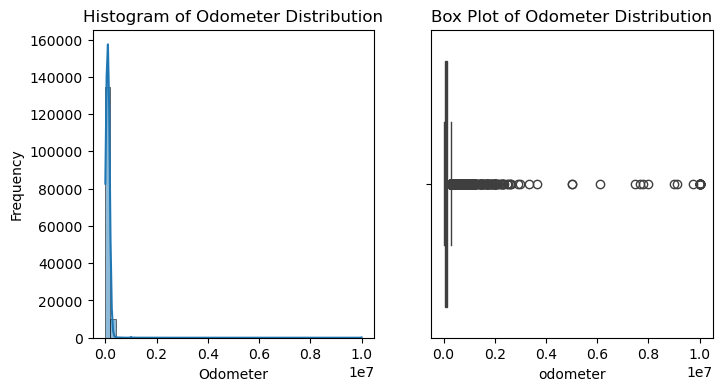

In [76]:
#Visualise odometer

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(df7['odometer'], bins=50, kde=True)
plt.title('Histogram of Odometer Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=df7['odometer'])
plt.title('Box Plot of Odometer Distribution')
plt.show()

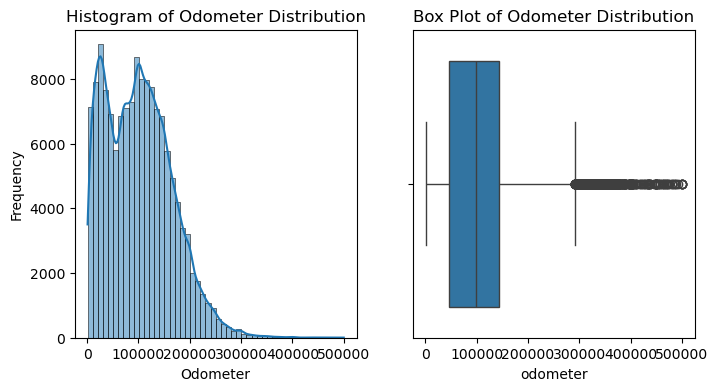

In [78]:
#remove samples with odometer<1000 (considered a new car)
#remove samples with odometer> 500,000 as they are unmarketable
df8= df7[(df7.odometer>1000) & (df7.odometer<=500000)]

#visualise 
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(df8['odometer'], bins=50, kde=True)
plt.title('Histogram of Odometer Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.boxplot(x=df8['odometer'])
plt.title('Box Plot of Odometer Distribution')
plt.show()

Age of vehicle feature

In [81]:
df8['vehicle_age'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]) 

count    143024.000000
mean         10.840684
std           9.184676
min          -1.000000
25%           5.000000
50%           9.000000
75%          14.000000
85%          17.000000
90%          19.000000
100%        121.000000
max         121.000000
Name: vehicle_age, dtype: float64

Text(0.5, 1.0, 'Box Plot of Age Distribution')

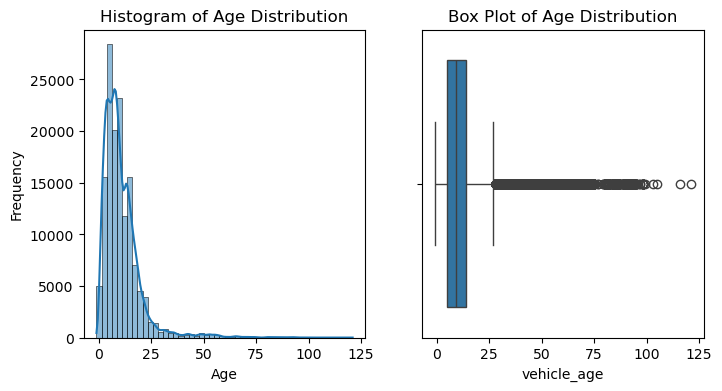

In [83]:
#visualise vehicle_age
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(df8['vehicle_age'], bins=50, kde=True)
plt.title('Histogram of Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
sns.boxplot(x=df8['vehicle_age'])
plt.title('Box Plot of Age Distribution')


In [96]:
#remove cars with age<=0 (errors or new cars)
#split our data into: vintage-classic cars (age>=30) and non vintage cars (age<30)

#non vintage cars
df_nonvintage= df8[(df8.vehicle_age>0) & (df8.vehicle_age<30)]

#vintage cars
df_vintage= df8[(df8.vehicle_age>=30) & (df8.vehicle_age<=100)]

Checking for Duplicates with our final data

In [99]:
print('Duplicates in nonvintage data:\n ', df_nonvintage.duplicated().sum())
#removing duplicates
df_nonvintage= df_nonvintage.drop_duplicates()
print('Duplicates in nonvintage data:\n ', df_nonvintage.duplicated().sum())

Duplicates in nonvintage data:
  34750
Duplicates in nonvintage data:
  0


One hot encoding

In [92]:
#non vintage cars
df_nonvintage_encoded= pd.get_dummies(df_nonvintage, columns=['manufacturer', 'condition', 'fuel','transmission', 'drive',
                                      'paint_color', 'state'],  dtype=int, prefix='', prefix_sep='')


#remove 1 level from each categorical feature to avoid multicollinearity
#state= nd (least count), pain_color=custom, fuel= other, transmission= other, drive= rwd  (least count), 
#condition= salvage (least count), manufacturer= other 
df_nonvintage_encoded.drop(['nd','other','custom','other','other','rwd','salvage'], axis='columns', inplace=True)

# Modeling and Evaluation

In [101]:
#split into x(input) and y (target/output)

x_nonvintage=df_nonvintage_encoded.drop('price', axis='columns')
y_nonvintage= df_nonvintage_encoded.price

Split to train and test

In [103]:
from sklearn.model_selection import train_test_split

#since nonvintage cars dataset contains 102,433 samples an 80/20 split will suffice
x_nonvintage_train, x_nonvintage_test,y_nonvintage_train, y_nonvintage_test= train_test_split(x_nonvintage, y_nonvintage, 
                                                                                              test_size= 0.2, random_state=123) 

Linear regression

In [115]:
from sklearn.linear_model import LinearRegression

lr_nonvintage= LinearRegression()

#fit 
lr_nonvintage.fit(x_nonvintage_train, y_nonvintage_train)
#evaluete the model
lr_nonvintage.score(x_nonvintage_test, y_nonvintage_test)

0.6896305626408984

An R squared score of 69% is not bad but still need to improve the model

In [118]:
# k-fold Cross Validation 

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

#shufflesplit will randomise the sample to ensure each fold will have equal distribution 
#of each of the data samples and is not targeted to one area
cv= ShuffleSplit(n_splits= 5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), x_nonvintage, y_nonvintage, cv=cv)

array([0.69093635, 0.68993584, 0.6933841 , 0.69379791, 0.69153015])

In each fold results remain around 69%.

We will test different regression models.

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [124]:
#define function to test different models using GridSearchCV for parameter tuning
def find_best_model_using_gridsearchcv(X, y):
    algorithms = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 1],  # Adjusted alpha values
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algorithms.items():
        try:
            gs = GridSearchCV(config['model'], config['params'], cv=cv,
                              return_train_score=False, n_jobs=-1)
            gs.fit(X, y)
            scores.append({
                'model': algo_name,
                'best_score_': gs.best_score_,
                'best_params_': gs.best_params_
            })
        except Exception as e:
            print(f"Error in {algo_name}: {e}")

    return pd.DataFrame(scores)

# Call the function
results = find_best_model_using_gridsearchcv(x_nonvintage, y_nonvintage)
results


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+12, tolerance: 1.003e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+12, tolerance: 1.006e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+12, toler

,model,best_score_,best_params_
0,linear_regression,0.691917,{'fit_intercept': True}
1,lasso,0.691905,"{'alpha': 0.1, 'selection': 'cyclic'}"
2,decision_tree,0.686209,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [126]:

def find_best_model_using_gridsearchcv(X, y):
    algorithms = {
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50,100]}}
        ,

        'xgboost': {
            'model': xgb.XGBRegressor(),
            'params':{
                'n_estimators': [100, 200], 
                'max_depth': [3, 5]}}}
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algorithms.items():
        try:
            gs = GridSearchCV(config['model'], config['params'], cv=cv,
                              return_train_score=False, n_jobs=-1)
            gs.fit(X, y)
            scores.append({
                'model': algo_name,
                'best_score_': gs.best_score_,
                'best_params_': gs.best_params_
            })
        except Exception as e:
            print(f"Error in {algo_name}: {e}")

    return pd.DataFrame(scores)

# Call the function 
results_ = find_best_model_using_gridsearchcv(x_nonvintage, y_nonvintage)
results_


,model,best_score_,best_params_
0,random_forest,0.822681,{'n_estimators': 100}
1,xgboost,0.804123,"{'max_depth': 5, 'n_estimators': 200}"


Random Forest has the best performance with a score of 82%

In [128]:
rf= RandomForestRegressor(n_jobs=-1)
rf.fit(x_nonvintage_train, y_nonvintage_train)
rf.score(x_nonvintage_test, y_nonvintage_test)

0.8188879990432555

In [129]:
#check feature importance using generated random forest 
imp=rf.feature_importances_
col= x_nonvintage_train.columns
imp_df= pd.DataFrame([imp], columns=col) 

#sum all the levels within each category
manufacturer= imp_df.loc[:,'acura':'volvo'].sum(axis=1).values[0]
paint_color= imp_df.loc[:,'black':'yellow'].sum(axis=1).values[0]
state= imp_df.loc[:,'ak':'wy'].sum(axis=1).values[0]
transmission= imp_df.loc[:,'automatic':'manual'].sum(axis=1).values[0]
drive= imp_df.loc[:,'4wd':'fwd'].sum(axis=1).values[0]
fuel= imp_df.loc[:,'diesel':'hybrid'].sum(axis=1).values[0]
condition= imp_df.loc[:,'excellent':'new'].sum(axis=1).values[0]

imp= pd.DataFrame({ 'manufacturer': [manufacturer], 'paint_color' : [paint_color], 'state': [state], 
                   'transmission': [transmission], 'drive': [drive], 'fuel': [fuel], 'condition': [condition]})


pd.concat([imp, imp_df.iloc[:,:2] ], axis=1)

,manufacturer,paint_color,state,transmission,drive,fuel,condition,odometer,vehicle_age
0,0.089665,0.030273,0.062483,0.014526,0.123813,0.050787,0.02187,0.189322,0.417261


We will remove features with less than 5% significancce: paint_color, transmission, condition

In [131]:
#select columns to be removed
trans= x_nonvintage_train.loc[:,'automatic':'manual'].columns.tolist()
color= x_nonvintage_train.loc[:,'black':'yellow'].columns.tolist()
cond= x_nonvintage_train.loc[:,'excellent':'new'].columns.tolist()

#combine those columns
col_remove= trans+color+cond

#modify both train and test sets
x_nonvintage_reduced =x_nonvintage.drop(columns= col_remove)
y_nonvintage_reduced =y_nonvintage.drop(columns= col_remove)
x_nonvintage_train_reduced =x_nonvintage_train.drop(columns= col_remove)
x_nonvintage_test_reduced= x_nonvintage_test.drop(columns= col_remove)
y_nonvintage_train_reduced =y_nonvintage_train.drop(columns= col_remove)
y_nonvintage_test_reduced= y_nonvintage_test.drop(columns= col_remove)

Implement Random Forest on the reduced data

In [133]:
rf_reduced= RandomForestRegressor(n_jobs=-1)
rf_reduced.fit(x_nonvintage_train_reduced, y_nonvintage_train_reduced)
rf_reduced.score(x_nonvintage_test_reduced, y_nonvintage_test_reduced)

0.796924003270452

Model performance did not improve after removing insignificant features.

In [135]:
# try with the second best model: xgboost

cv= ShuffleSplit(n_splits= 5, test_size=0.2, random_state=0)

cross_val_score(xgb.XGBRegressor(n_jobs=-1), x_nonvintage_reduced, y_nonvintage_reduced, cv=cv)

array([0.78394425, 0.78353012, 0.78449309, 0.78572464, 0.7860465 ])

Removing features did not improve our model. We will keep all features

# Testing our chosen Model

In [138]:
rf= RandomForestRegressor(n_jobs=-1)
rf.fit(x_nonvintage_train, y_nonvintage_train)
rf.score(x_nonvintage_test, y_nonvintage_test)

0.8195194967617228

In [139]:
def predict_price(manufacturer, condition, fuel, odometer, transmission, drive, paint_color, state, vehicle_age):
    # Initialize an array of the size of all the columns in x_nonvintage
    x = np.zeros(len(x_nonvintage.columns)) 

    #set first two indices to our numeric features
    x[0] = odometer              
    x[1] = vehicle_age

    # list of categorical features
    features = [state, manufacturer, condition, fuel, transmission, paint_color, drive]
    
    # for all categores in a categorical feature, loop over the categories
    for category in features:
        
        # Check if the category is in our data x_nonvintage
        if category in x_nonvintage.columns:
            
            # Get the index for the one hot encoded category in that data
            idx = np.where(x_nonvintage.columns == category)[0][0]

            #set that category index=1 (categories for that categorical feature that are not in x_nonvintage will be 0)
            x[idx] = 1
       
    # prediction
    return rf.predict([x])[0]


In [173]:
predict_price('bmw', 'like-new', 'diesel', 120000, 'automatic', '4wd', 'black', 'la', 5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


19032.39

In [175]:
predict_price('bmw', 'good', 'diesel', 120000, 'automatic', '4wd', 'black', 'la', 3)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20898.346666666665

In [177]:
predict_price('bmw', 'like-new', 'diesel', 120000, 'automatic', '4wd', 'black', 'ny', 5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


28201.78

In [179]:
predict_price('bmw', 'good', 'diesel', 120000, 'automatic', '4wd', 'black', 'ny', 3)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


31265.77

In [181]:
import pickle
with open('/Users/marwa/Desktop/2ndHCP/model/rf_model', 'wb') as f:
    pickle.dump(rf, f)

In [183]:
import json
columns = {
    'data_columns' : [col.lower() for col in x_nonvintage.columns]
}

with open('/Users/marwa/Desktop/2ndHCP/model/columns', 'w') as f:
    f.write(json.dumps(columns))